In [273]:
import numpy as np
import pandas as pd
import itertools

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import yfinance as yf
import datetime

In [274]:
def stationarity_test(X, cutoff=0.01, print_results=False):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
    else:
        pass
    return pvalue

def cointegration_test(X, Y, cutoff=0.1, print_results=False):
    #Engle-Granger test for cointegration
    score, pvalue, _ = coint(X, Y)
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + ' The pair ' + X.name + ' and ' + Y.name + ' is likely cointegrated.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + ' The pair ' + X.name + Y.name + ' is likely not cointegrated.')
    else:
        pass
    return pvalue

In [277]:
stock_list = ['ABEV', "MDLZ", "CAG", "KDP", "KHC", "MNST", "GIS", "K", "MKC", "CCEP", "HRL", "TAP", "IFF", "ADM", "VDC", "XLP", "IYK", "FTXG"]
end_date = pd.Timestamp.today()
start_date =  end_date - pd.Timedelta(days = 365)
df = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  18 of 18 completed


In [278]:
stock_pairs = list(itertools.combinations(df.columns, 2))
cointegration_results_df = pd.DataFrame(index=range(len(stock_pairs)),columns=['Stock 1', 'Stock 2', 'Coint. P-Value'])

for i, pair in enumerate(stock_pairs):
    df_pairs = df[list(pair)]
    pvalue = cointegration_test(df_pairs[pair[0]], df_pairs[pair[1]], print_results = True)
    cointegration_results_df['Stock 1'][i] = pair[0]
    cointegration_results_df['Stock 2'][i] = pair[1]
    cointegration_results_df['Coint. P-Value'][i] = pvalue

sorted_coint_df = cointegration_results_df.sort_values(by='Coint. P-Value', ascending = True)
print(sorted_coint_df)


p-value = 0.009793176001791764 The pair ABEV and MKC is likely cointegrated.
p-value = 0.07532314389283312 The pair ABEV and VDC is likely cointegrated.
p-value = 0.04092573127697919 The pair CAG and KHC is likely cointegrated.
p-value = 0.032941000619679375 The pair CCEP and KDP is likely cointegrated.
p-value = 0.047458508602307437 The pair FTXG and K is likely cointegrated.
p-value = 0.05633628646132024 The pair IFF and KHC is likely cointegrated.
p-value = 0.01958167789412297 The pair IYK and K is likely cointegrated.
p-value = 0.0021994832690086738 The pair IYK and MKC is likely cointegrated.
p-value = 0.0019510781598299281 The pair MDLZ and MNST is likely cointegrated.
    Stock 1 Stock 2 Coint. P-Value
139    MDLZ    MNST       0.001951
112     IYK     MKC       0.002199
12     ABEV     MKC       0.009793
108     IYK       K       0.019582
54     CCEP     KDP       0.032941
..      ...     ...            ...
44      CAG    MNST       0.990604
43      CAG     MKC       0.991234
4

<Axes: xlabel='Date'>

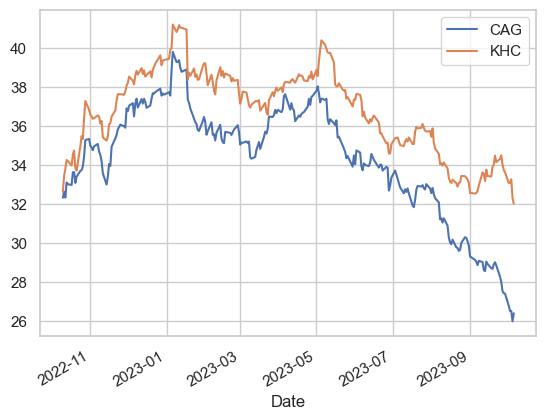

In [297]:
stock_1 = 'CAG'
stock_2 = 'KHC'

df[[stock_1, stock_2]].plot()

In [298]:
Y = df[stock_1]
X = df[stock_2]
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
spread = Y - model.predict()
spread = spread.rename("Spread")

<Axes: xlabel='Date'>

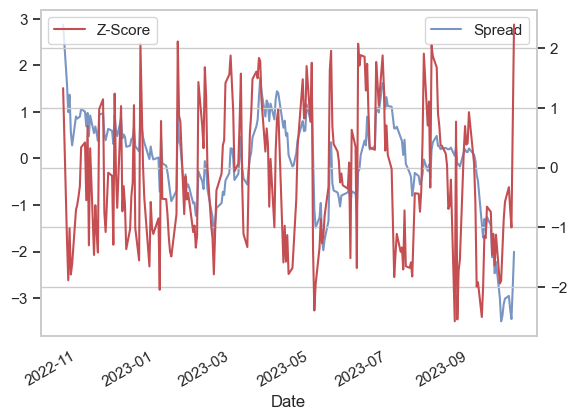

In [302]:
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = ((spread - spread_mean)/spread_std)
first_valid_idx = zscore.first_valid_index()
zscore = zscore.rolling(window=1).mean().dropna().rename("Z-Score")

#spread.plot(color='r', alpha=0.5, grid=False)
#ax2 = plt.twinx()
#zscore.plot(ax=ax2, color='b')

plot_df_zscore = pd.merge(spread, zscore, right_index = True, left_index = True)
plot_df_zscore.plot(y='Spread', grid=False, color='b', alpha=0.75)
ax2 = plt.twinx()
plot_df_zscore.plot(y='Z-Score', ax=ax2, color='r')

<Axes: xlabel='Date'>

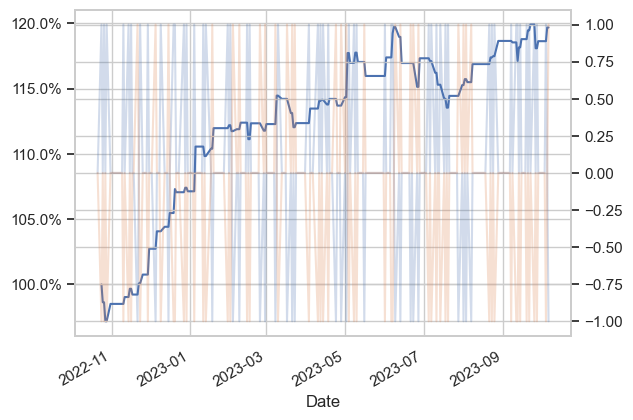

In [303]:
factor = 1
entry_threshold = 1 * factor
exit_threshold = 2 * factor

stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)

for i in range(1, len(zscore)):
    if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = 1
        stock2_position.iloc[i] = -1
    elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = -1
        stock2_position.iloc[i] = 1
    elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0
        stock2_position.iloc[i] = 0
    else:
        stock1_position.iloc[i]=stock1_position.iloc[i-1]
        stock2_position.iloc[i]=stock2_position.iloc[i-1]

stock1_returns = df[stock_1][first_valid_idx:].pct_change() * stock1_position.shift(1).fillna(0)
stock2_returns = df[stock_2][first_valid_idx:].pct_change() * stock2_position.shift(1).fillna(0)


import matplotlib.ticker as mtick

total_returns = stock1_returns + stock2_returns
cumulative_returns = (1 + total_returns).cumprod()*100
cumulative_returns.plot().yaxis.set_major_formatter(mtick.PercentFormatter())
ax2 = plt.twinx()
stock1_position.plot(ax=ax2, alpha = 0.25)
stock2_position.plot(ax=ax2, alpha = 0.25)


In [304]:
print(stock1_position.iloc[-1], stock_1)
print(stock2_position.iloc[-1], stock_2)

-1 CAG
1 KHC
